imports and txt file readings

In [5]:
import torch
import imageio
import os
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_dimcheck import dimchecked
import sys
import cv2
import re

sys.path.append('../../models/disk')
from disk import DISK, Features
from disk.geom import distance_matrix

sys.path.append('../../models/SuperGlue')
from models.superpoint import SuperPoint
from models.superglue import SuperGlue
from torchvision import transforms 

Device Agnostic Code

In [ ]:

# set superpoints and superglue to device, which we want cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
# Open the cam1, cam2 text files
with open('data_bruh\cam1.txt', 'r') as file:
    # Read the content of the file
    content1 = file.read()
    
with open('data_bruh\cam2.txt', 'r') as file:
    # Read the content of the file
    content2 = file.read()

# Imports for detecting feature points (DISK)

In [ ]:

# Convert image to tensor
def image_to_tensor(image, device):
    """
    Change image to tensor form

    :param image: input image
    :param device: "cuda" if torch.cuda.is_available() else "cpu"
    :return output image: image with shape (b, c, h, w) which set to device
    """
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale so the dimension will become 2 [height, weight]
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0).to(device)

# Define Image class for handling image resizing, padding, etc.
class Image:
    def __init__(self, bitmap: ['C', 'H', 'W'], fname: str, orig_shape=None):
        self.bitmap = bitmap
        self.fname = fname
        if orig_shape is None:
            self.orig_shape = self.bitmap.shape[1:]
        else:
            self.orig_shape = orig_shape

    def resize_to(self, shape):
        return Image(
            self._pad(self._interpolate(self.bitmap, shape), shape),
            self.fname,
            orig_shape=self.bitmap.shape[1:],
        )

    @dimchecked
    def to_image_coord(self, xys: [2, 'N']) -> ([2, 'N'], ['N']):
        f, _size = self._compute_interpolation_size(self.bitmap.shape[1:])
        scaled = xys / f

        h, w = self.orig_shape
        x, y = scaled

        mask = (0 <= x) & (x < w) & (0 <= y) & (y < h)

        return scaled, mask

    def _compute_interpolation_size(self, shape):
        x_factor = self.orig_shape[0] / shape[0]
        y_factor = self.orig_shape[1] / shape[1]

        f = 1 / max(x_factor, y_factor)

        if x_factor > y_factor:
            new_size = (shape[0], int(f * self.orig_shape[1]))
        else:
            new_size = (int(f * self.orig_shape[0]), shape[1])

        return f, new_size

    @dimchecked
    def _interpolate(self, image: ['C', 'H', 'W'], shape) -> ['C', 'h', 'w']:
        _f, size = self._compute_interpolation_size(shape)
        return F.interpolate(
            image.unsqueeze(0),
            size=size,
            mode='bilinear',
            align_corners=False,
        ).squeeze(0)

    @dimchecked
    def _pad(self, image: ['C', 'H', 'W'], shape) -> ['C', 'h', 'w']:
        x_pad = shape[0] - image.shape[1]
        y_pad = shape[1] - image.shape[2]

        if x_pad < 0 or y_pad < 0:
            raise ValueError("Attempting to pad by negative value")

        return F.pad(image, (0, y_pad, 0, x_pad))


# Function to extract features and descriptors from a single image with thresholding
def disk_process(image_path, model, threshold=0.0):

    # Load and preprocess images
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image at {image_path} could not be loaded.")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = image_to_tensor(image_rgb, device)

    #--------------------------------------------------------------
    img = np.ascontiguousarray(imageio.imread(image_path))
    tensor = torch.from_numpy(img).to(torch.float32)

    if len(tensor.shape) == 2:  # If grayscale image, expand to 3 channels
        tensor = tensor.unsqueeze(-1).expand(-1, -1, 3)

    bitmap = tensor.permute(2, 0, 1) / 255.  # Normalize image
    image = Image(bitmap, os.path.splitext(os.path.basename(image_path))[0])

    bitmap = bitmap.unsqueeze(0)  # Add batch dimension
    bitmap = bitmap.to(DEV, non_blocking=True)

    with torch.no_grad():
        features = model.features(bitmap, kind='nms').flat[0].to(CPU)

    keypoints = features.kp.T
    descriptors = features.desc
    scores = features.kp_logp

    # Apply threshold to scores
    valid_idx = scores > threshold
    keypoints = keypoints[:, valid_idx]
    descriptors = descriptors[valid_idx, :]
    scores = scores[valid_idx]

    return keypoints.numpy(), descriptors.numpy(), scores.numpy(), image_tensor

def format_keypoints(keypoints):
    keypoints_reshape = []
    for i, y in enumerate(keypoints[1]):
        keypoints_reshape.append([keypoints[0][i], y])

    keypoints_reshape = np.array(keypoints_reshape)

    return keypoints_reshape

# Imports for Feature Matching (DISK)

In [ ]:
def match(desc_1, desc_2, rt=1.):
    matched_pairs = _match(desc_1, desc_2, rt)
    matches = matched_pairs.cpu().numpy()
    return matches

def _binary_to_index(binary_mask: torch.Tensor, ix2: torch.Tensor) -> torch.Tensor:
    return torch.stack([
        torch.nonzero(binary_mask)[:, 0],
        ix2
    ], dim=0)

def _ratio_one_way(dist_m: torch.Tensor, rt: float) -> torch.Tensor:
    val, ix = torch.topk(dist_m, k=2, dim=1, largest=False)
    ratio = val[:, 0] / val[:, 1]
    passed_test = ratio < rt
    ix2 = ix[passed_test, 0]
    return _binary_to_index(passed_test, ix2)

def _match_chunkwise(ds1: torch.Tensor, ds2: torch.Tensor, rt: float) -> torch.Tensor:
    MAX_FULL_MATRIX = 10000**2
    chunk_size = MAX_FULL_MATRIX // ds1.shape[0]
    matches = []
    start = 0

    while start < ds2.shape[0]:
        ds2_chunk = ds2[start:start+chunk_size]
        dist_m = distance_matrix(ds1, ds2_chunk)
        one_way = _ratio_one_way(dist_m, rt)
        one_way[1] += start
        matches.append(one_way)
        start += chunk_size

    return torch.cat(matches, dim=1)

def _match(ds1: torch.Tensor, ds2: torch.Tensor, rt: float) -> torch.Tensor:
    fwd = _match_chunkwise(ds1, ds2, rt)
    bck = _match_chunkwise(ds2, ds1, rt)
    bck = torch.flip(bck, (0,))

    merged = torch.cat([fwd, bck], dim=1)
    unique, counts = torch.unique(merged, dim=1, return_counts=True)

    return unique[:, counts == 2]

def match_brute(desc_1, desc_2):
    # Compute the distance between all pairs (Brute-Force Matching)
    dist_m = distance_matrix(desc_1, desc_2)
    
    # Find the best matches
    val, ix = torch.topk(dist_m, k=1, dim=1, largest=False)
    
    # Return a 2D array format with match indices
    matches_1 = torch.arange(desc_1.shape[0], device=desc_1.device)  # Ensure matches_1 is on the same device
    matches_2 = ix.squeeze(1)  # Best match indices in image 2
    
    # Stack into a 2D format: [[matches from image 1], [matches from image 2]]
    matches = torch.stack([matches_1, matches_2], dim=0)
    
    return matches



def match_images(desc_1, desc_2, rt=0.8, use_brute=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    desc_1 = torch.tensor(desc_1, dtype=torch.float32).to(device)
    desc_2 = torch.tensor(desc_2, dtype=torch.float32).to(device)
    
    if use_brute:
        # Use Brute-Force Matching
        matches = match_brute(desc_1, desc_2)
    else:
        # Use Ratio Test Matching
        matches = match(desc_1, desc_2, rt)
        
    num_matches = matches.shape[1]
    
    # Calculate match scores (you may want to adjust this based on your needs) 
    dist_matrix = distance_matrix(desc_1[matches[0]], desc_2[matches[1]])
    match_scores = 1 - dist_matrix.diagonal().cpu().numpy()
    
    return matches, match_scores, num_matches


For visualizing

In [ ]:
def visualize_matches(image_path1, image_path2, kp1, kp2, scores1, scores2, scaling_factor=1):
    img1 = imageio.imread(image_path1)
    img2 = imageio.imread(image_path2)

    # Scale images
    img1 = cv2.resize(img1, (int(img1.shape[1] * scaling_factor), int(img1.shape[0] * scaling_factor)))
    img2 = cv2.resize(img2, (int(img2.shape[1] * scaling_factor), int(img2.shape[0] * scaling_factor)))

    # Scale keypoints accordingly
    kp1_scaled = kp1 * scaling_factor
    kp2_scaled = kp2 * scaling_factor

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].imshow(img1)
    ax[0].scatter(kp1_scaled[0, :], kp1_scaled[1, :], c=scores1, cmap='jet', s=40, edgecolors='white')
    ax[0].set_title("Image 1 Keypoints (DISK)")

    ax[1].imshow(img2)
    ax[1].scatter(kp2_scaled[0, :], kp2_scaled[1, :], c=scores2, cmap='jet', s=40, edgecolors='white')
    ax[1].set_title("Image 2 Keypoints (DISK)")

    # # Add match lines
    # for m in matches.T:
    #     pt1 = kp1_scaled[:, m[0]]
    #     pt2 = kp2_scaled[:, m[1]] + np.array([img1.shape[1], 0])  # Shift second point to match image2 placement

    #     ax[0].plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='green', lw=1)

    plt.show()

Main Loop to visualize feature detection(Try Try)

C:\Users\rensl\AppData\Local\Temp\ipykernel_2588\2480236098.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=CPU)


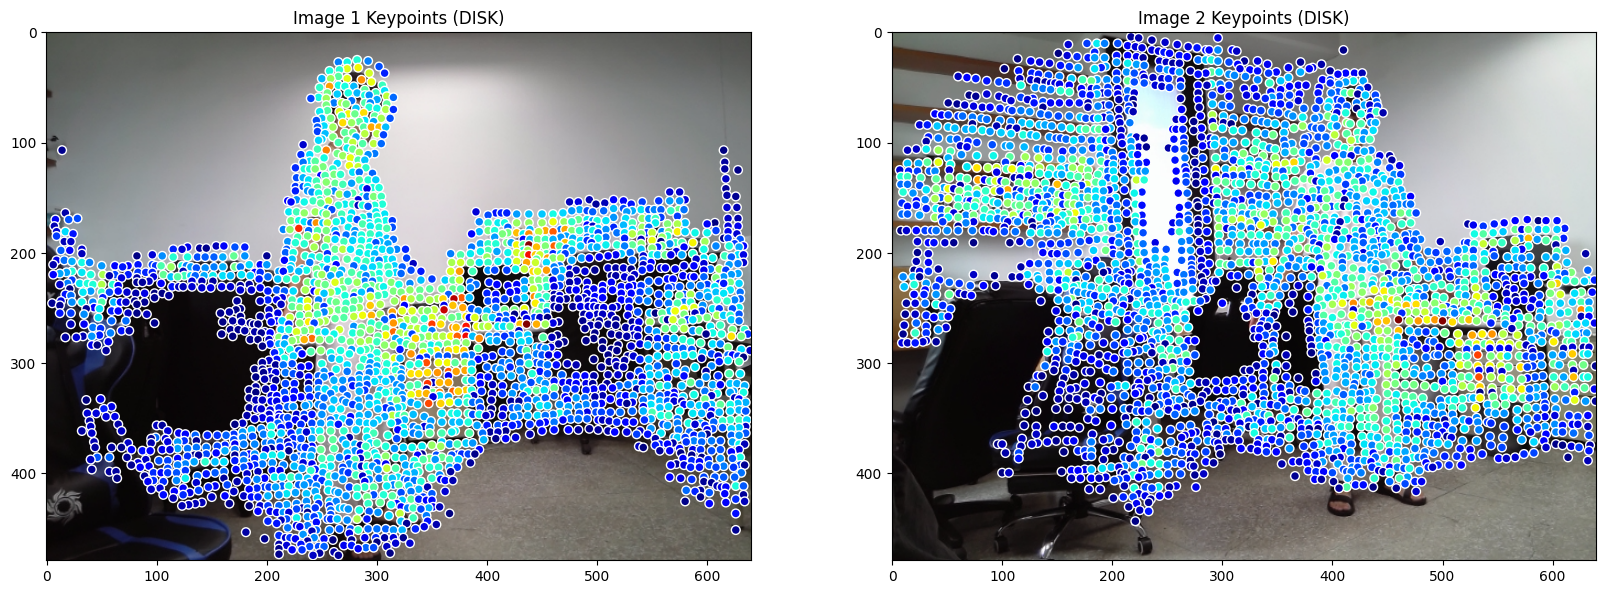

2469


In [ ]:
if __name__ == '__main__':
    # Device configuration
    DEV = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    CPU = torch.device('cpu')

    # Load the pre-trained model
    model_path = 'disk/epipolar-save.pth'
    state_dict = torch.load(model_path, map_location=CPU)

    if 'extractor' in state_dict:
        weights = state_dict['extractor']
    elif 'disk' in state_dict:
        weights = state_dict['disk']
    else:
        raise KeyError('Incompatible weight file!')

    # Initialize DISK model
    model = DISK(window=8, desc_dim=128)
    model.load_state_dict(weights)
    model = model.to(DEV)

    # Paths to the input images
    image_1 = 'data_bruh/cam1/cam1_20240912_120234_0001.png'
    image_2 = 'data_bruh/cam2/cam2_20240912_120234_0001.png'

    # Set the threshold for keypoint detection
    threshold = -1

    # Extract keypoints, descriptors, and scores for both images
    keypoints_1, descriptors_1, scores_1, _ = disk_process(image_1, model, threshold)
    keypoints_2, descriptors_2, scores_2, _ = disk_process(image_2, model, threshold)

    # keypoints_1 = format_keypoints(keypoints_1)
    # keypoints_2 = format_keypoints(keypoints_2)

    # Match descriptors between the two images
    descriptors_1 = torch.from_numpy(descriptors_1)
    descriptors_2 = torch.from_numpy(descriptors_2)

    # Visualize the matches
    visualize_matches(image_1, image_2, keypoints_1, keypoints_2, scores_1, scores_2)
    print(len(keypoints_1[0]))

Main Loop

In [ ]:
if __name__ == '__main__':
    # Device configuration
    DEV = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    CPU = torch.device('cpu')

    # Load the pre-trained model
    model_path = 'disk/depth-save.pth'
    state_dict = torch.load(model_path, map_location=CPU)

    if 'extractor' in state_dict:
        weights = state_dict['extractor']
    elif 'disk' in state_dict:
        weights = state_dict['disk']
    else:
        raise KeyError('Incompatible weight file!')

    # Initialize DISK model
    model = DISK(window=8, desc_dim=128)
    model.load_state_dict(weights)
    model = model.to(DEV)

    # Paths to the input images
    image_1 = 'data_bruh/cam1/cam1_20240912_120234_0001.png'
    image_2 = 'data_bruh/cam2/cam2_20240912_120234_0001.png'

    # Set the threshold for keypoint detection
    threshold = 0.0

    # Extract keypoints, descriptors, and scores for both images
    keypoints_1, descriptors_1, scores_1, _ = disk_process(image_1, model, threshold)
    keypoints_2, descriptors_2, scores_2, _ = disk_process(image_2, model, threshold)

    keypoints_1 = format_keypoints(keypoints_1)
    keypoints_2 = format_keypoints(keypoints_2)

    # Match descriptors between the two images
    descriptors_1 = torch.from_numpy(descriptors_1)
    descriptors_2 = torch.from_numpy(descriptors_2)


C:\Users\rensl\AppData\Local\Temp\ipykernel_2588\359109354.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=CPU)


In [ ]:
lines_1 = content1.strip().splitlines()
lines_2 = content2.strip().splitlines()

folder_match = "data_bruh/cam_match"
if os.path.exists(f"{folder_match}.txt"):
    os.remove(f"{folder_match}.txt")
    print("Previous txt file has been deleted.")

Previous txt file has been deleted.


In [ ]:
def get_matching_keypoints_indices(keypoints_hrnet, keypoints_disk, tolerance_range):
    """
    Filter keypoints based on whether they match descriptor keypoints within a given tolerance range.
    
    :param keypoints: List of [x, y] keypoints from the HigherHRNet.
    :param descriptor_keypoints: List of [x, y] keypoints from disk(disk model) .
    :param tolerance_range: Maximum allowed difference between keypoints to consider a match(ensure we can get an approximately points).
    
    :return: Filtered list of matching keypoints and its indices from keypoints_disk that match the keypoints_hrnet.

    """
    matching_keypoints = []
    matching_indices = []
    total_error = 0

    for kp in keypoints_hrnet:
        for idx, desc_kp in enumerate(keypoints_disk):
            # Check if both x and y are within the tolerance range
            total_error += abs(kp[0] - desc_kp[0])
            total_error += abs(kp[1] - desc_kp[1])
            if (abs(kp[0] - desc_kp[0]) <= tolerance_range and
                abs(kp[1] - desc_kp[1]) <= tolerance_range):
                matching_indices.append(idx)
                matching_keypoints.append(kp)
                break  # Stop checking other descriptor keypoints for this keypoint
    
    print (total_error / idx)
    return matching_keypoints, matching_indices

In [ ]:
# initialize the both module
config = {
    'superglue': {
        'weights': 'indoor',
        'sinkhorn_iterations': 20,
        'match_threshold': 0.001 # Adjusted match_threshold
    }
}

# Load models
def load_models(config):
    """
    load SuperPoint and Superpoint model
    
    :param config: initialize the model
    :return models: superpoint, superglue
    """
    superglue = SuperGlue(config['superglue'])
    superglue.eval()
    return superglue

superglue = load_models(config)
superglue = superglue.to(device)


Loaded SuperGlue model ("indoor" weights)


c:\Users\rensl\Documents\Final_Project\SuperGlue\models\superglue.py:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(str(path)))


In [ ]:


# Match features between two sets of descriptors
def match_features(image1_tensor, keypoints1, desc1, scores1, image2_tensor, keypoints2, desc2, scores2, superglue):
    """
    Match features between two images using the SuperGlue model.

    :param image1_tensor: Tensor representation of the first image.
    :param keypoints1: Keypoints from the first image (list of [x, y] coordinates).
    :param desc1: Descriptors corresponding to the keypoints from the first image.
    :param scores1: Confidence scores for the keypoints in the first image.
    :param image2_tensor: Tensor representation of the second image.
    :param keypoints2: Keypoints from the second image (list of [x, y] coordinates).
    :param desc2: Descriptors corresponding to the keypoints from the second image.
    :param scores2: Confidence scores for the keypoints in the second image.
    :param superglue: The SuperGlue model used for feature matching.

    :return: 
        - matches: Array of indices indicating which keypoints in image 1 match with those in image 2. 
          A value of -1 indicates no match for that keypoint.
        - num_matches: Total number of valid matches found between the two images.
        - match_confidences: Confidence scores for each match, corresponding to `matches`.
    """
    device = next(superglue.parameters()).device  # Get device of superglue_model

    # Move inputs to the same device as the model
    keypoints1 = torch.tensor(keypoints1, dtype=torch.float32, device=device).unsqueeze(0)
    keypoints2 = torch.tensor(keypoints2, dtype=torch.float32, device=device).unsqueeze(0)
    desc1 = torch.tensor(desc1, dtype=torch.float32, device=device).unsqueeze(0)
    desc2 = torch.tensor(desc2, dtype=torch.float32, device=device).unsqueeze(0)
    scores1 = torch.tensor(scores1, dtype=torch.float32, device=device).unsqueeze(0)
    scores2 = torch.tensor(scores2, dtype=torch.float32, device=device).unsqueeze(0)
    image1_tensor = image1_tensor.to(device)
    image2_tensor = image2_tensor.to(device)

    # Prepare data dictionary for SuperGlue
    data = {
        'keypoints0': keypoints1,
        'keypoints1': keypoints2,
        'descriptors0': desc1,
        'descriptors1': desc2,
        'scores0': scores1,
        'scores1': scores2,
        'image0': image1_tensor,
        'image1': image2_tensor
    }
    
    with torch.inference_mode():
        output = superglue(data)
    
    # Extract matches and confidences
    matches = output['matches0'][0].cpu().numpy()
    match_confidences = output['matching_scores0'][0].cpu().numpy()

    # print(f"Number of matches found: {np.sum(matches > -1)}")
    # print(f"Matches array: {matches}")

    num_matches = np.sum(matches > -1)
    
    return matches, num_matches, match_confidences

def visualize_matches(image1, keypoints1, image2, keypoints2, matches, scores1, scores2, confidences, counting):
    """
    Visualize the matching keypoints between two images.

    :param image1: The first image (RGB format).
    :param keypoints1: Keypoints detected in the first image (list of [x, y] coordinates).
    :param image2: The second image (RGB format).
    :param keypoints2: Keypoints detected in the second image (list of [x, y] coordinates).
    :param matches: Array of match indices where each value is the index of the matched keypoint 
                    in the second image, or -1 if there is no match.
    :param scores1: Confidence scores for the keypoints in the first image.
    :param scores2: Confidence scores for the keypoints in the second image.
    :param confidences: Confidence scores of the matches between the two images.
    :param counting: An identifier for the current visualization, typically used to distinguish between multiple comparisons.

    :return: None. visualize matches between the two images.
    """
    keypoints1 = np.array(keypoints1)
    keypoints2 = np.array(keypoints2)
    scores1 = np.array(scores1)
    scores2 = np.array(scores2)

    plt.figure(figsize=(10, 10))
    plt.imshow(np.hstack([image1, image2]))
    
    plt.scatter(keypoints1[:, 0], keypoints1[:, 1], c=scores1, cmap='jet', s=10, label='Keypoints 1')
    plt.scatter(keypoints2[:, 0] + image1.shape[1], keypoints2[:, 1], c=scores2, cmap='jet', s=10, label='Keypoints 2')

    for i, match in enumerate(matches[0]):     
        confidence = confidences[i]
        plt.plot([keypoints1[match, 0], keypoints2[matches[1][i], 0] + image1.shape[1]],
                    [keypoints1[match, 1], keypoints2[matches[1][i], 1]], color=plt.cm.jet(confidence), lw=1)
    
    plt.legend()
    plt.colorbar(label='Confidence')
    plt.title(f"Image {counting} compares")
    plt.show()  # Display the plot

def display_keypoints(keypoints, title="keypoints"):
    '''
    display keypoints DataFrame using pandas
    '''
    df = pd.DataFrame(keypoints, columns = ['x', 'y'])
    display(df)

def return_match_keypoints(keypoints_1, keypoints_2, matches, confidences):
    """
    Retrieve matched keypoints and their confidence scores.

    :param keypoints_1: List of keypoints from the first image.
    :param keypoints_2: List of keypoints from the second image.
    :param matches: Array of match indices where each index points to the corresponding match in keypoints_2 or -1 if no match.
    :param confidences: Array of confidence scores associated with each match.
    :return: List containing matched keypoints from both images along with their confidence scores.
    """
    result = []
    for i, match_idx1 in enumerate(matches[0]):
        result.extend([keypoints_1[match_idx1], keypoints_2[matches[1][i]], [confidences[i]]])

    return result

In [ ]:
# Device configuration
DEV = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CPU = torch.device('cpu')

# Load the pre-trained model
model_path = 'disk/epipolar-save.pth'
state_dict = torch.load(model_path, map_location=CPU)

if 'extractor' in state_dict:
    weights = state_dict['extractor']
elif 'disk' in state_dict:
    weights = state_dict['disk']
else:
    raise KeyError('Incompatible weight file!')

# Initialize DISK model
model = DISK(window=8, desc_dim=128)
model.load_state_dict(weights)
model = model.to(DEV)


C:\Users\rensl\AppData\Local\Temp\ipykernel_2588\13035228.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=CPU)


TRYTRY

In [ ]:
nigga = 5

In [ ]:
match2 = re.match(r'([^ ]+) (\[\[.*\]\])', lines_2[nigga])
if match2:
    address2 = match2.group(1)
    hrnet_coor2 = eval(match2.group(2))
match1 = re.match(r'([^ ]+) (\[\[.*\]\])', lines_1[nigga])
if match1:
    address1 = match1.group(1)
    hrnet_coor1 = eval(match1.group(2))

In [ ]:
address2, address1

('data_bruh\\cam2_pose\\cam2_20240912_120235_0006.png',
 'data_bruh\\cam1_pose\\cam1_20240912_120235_0006.png')

In [ ]:
keypoints_1, descriptors_1, scores_1, img_tensor1 = disk_process(address1, model, threshold = -10.0)
keypoints_2, descriptors_2, scores_2, img_tensor2 = disk_process(address2, model, threshold = -10.0)

keypoints_1 = format_keypoints(keypoints_1)
keypoints_2 = format_keypoints(keypoints_2)

In [ ]:
descriptors_1.shape

(2432, 128)

In [ ]:


# matching_keypoints and indices
filtered_keypoints_1, indices_hrt1 = get_matching_keypoints_indices(hrnet_coor1, keypoints_1, tolerance_range=5)
filtered_keypoints_2, indices_hrt2 = get_matching_keypoints_indices(hrnet_coor2, keypoints_2, tolerance_range=5)

score_hrt1 = scores_1[indices_hrt1]
score_hrt2 = scores_2[indices_hrt2]

descriptors_hrt1 = descriptors_1[indices_hrt1]
descriptors_hrt2 = descriptors_2[indices_hrt2]

descriptors_hrt1 = descriptors_hrt1
descriptors_hrt2 = descriptors_hrt2

print(f"filtered_keypoints_1.shape for {address1}: {np.array(filtered_keypoints_1).shape}")
print(f"filtered_keypoints_2.shape for {address2}: {np.array(filtered_keypoints_2).shape}")
print(f"descriptors_hrt1.shape for {address1}: {descriptors_hrt1.shape}")
print(f"descriptors_hrt2.shape for {address2}: {descriptors_hrt2.shape}")
print("\n")

1316.0715181932246
2160.1100984323734
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0006.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0006.png: (17, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0006.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0006.png: (17, 128)




In [ ]:
matches, scores, num_matches = match_images(descriptors_hrt1, descriptors_hrt2, 1)

matches, scores

(array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        [ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]],
       dtype=int64),
 array([ 0.05209345, -0.02222145,  0.11066115,  0.05631441,  0.0979383 ,
        -0.01107752,  0.22744346,  0.23486865,  0.18437785,  0.37950987,
        -0.13094962,  0.4251749 ,  0.1844387 ,  0.16702175], dtype=float32))

1318.6943507588533
2131.288721804511
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120234_0001.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120234_0001.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120234_0001.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120234_0001.png: (16, 128)


[[ 1  3  4  5  8 10 12 13 15]
 [ 1  2  4 11  8 10 12 13 15]] 
 [-0.03319693  0.02031791  0.07739377 -0.12361801  0.10236514 -0.0417496
  0.13741279 -0.10768545 -0.06830525]
9 of keypoints are match


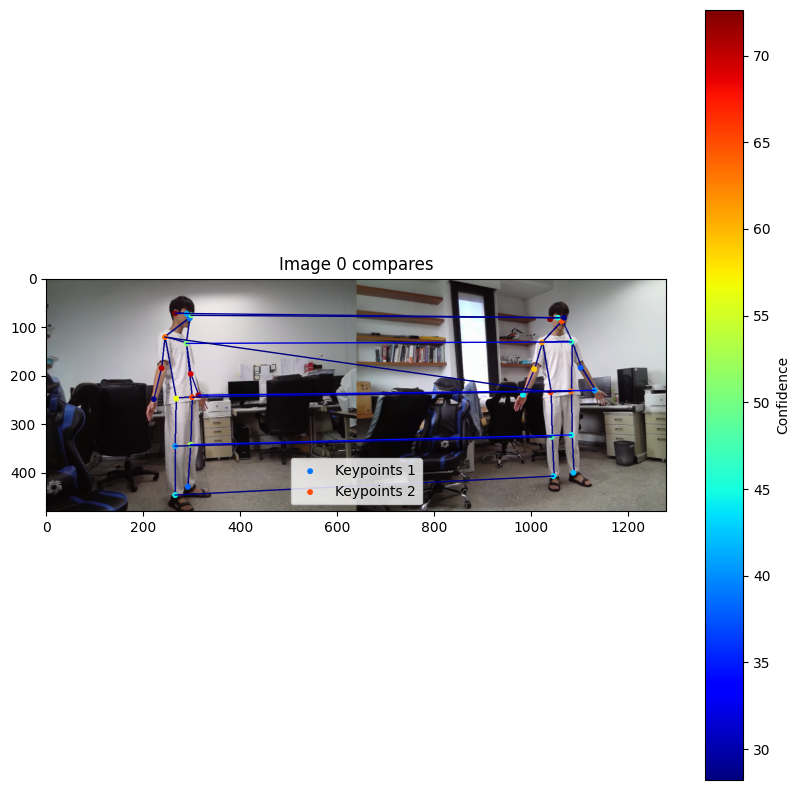

1337.3957641196014
2132.3656074766354
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120234_0002.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120234_0002.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120234_0002.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120234_0002.png: (16, 128)


[[ 1  3  4  5  6  8 10 11 12 15]
 [ 1  2  4  5  6  8 10 11 13 15]] 
 [-0.0353514   0.04619145  0.02375585  0.06626356 -0.09580553 -0.05468237
 -0.0288384   0.23363394 -0.08696115 -0.06337214]
10 of keypoints are match


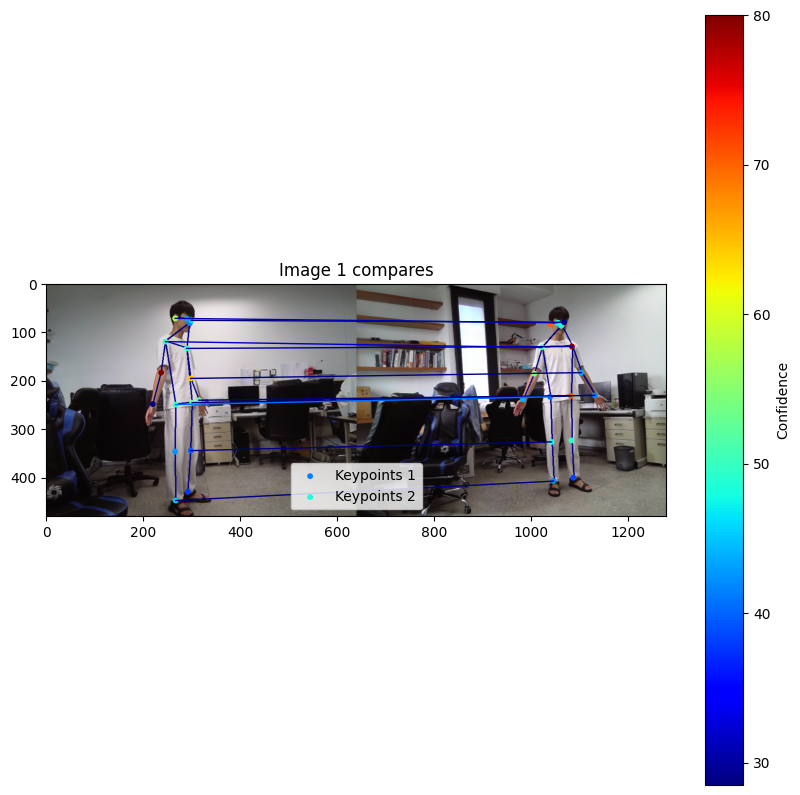

1339.7218235542423
2140.15441999254
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0003.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0003.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0003.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0003.png: (16, 128)


[[ 2  4  5  6  8 10 11 12 15]
 [ 1  4  5 13  8 10 11 12 15]] 
 [-0.1272304  -0.04928076  0.064448   -0.18310618 -0.02505934  0.18066335
  0.21050036 -0.10237539 -0.09605682]
9 of keypoints are match


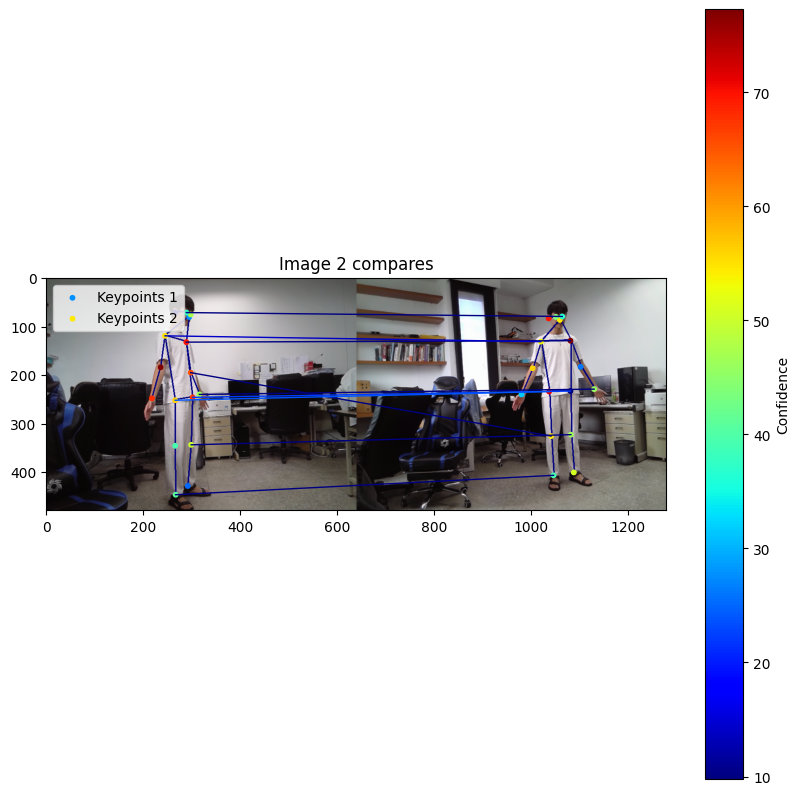

1333.243736730361
2120.4756957328386
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0004.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0004.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0004.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0004.png: (16, 128)


[[ 1  3  5  6  7  8 10 11 12 14]
 [ 1  2  5  6  7  8 10 11 13 14]] 
 [-0.02993345 -0.12463367  0.01000828 -0.09107196 -0.17058635  0.09275138
 -0.08361638  0.15424621 -0.09681642  0.01548386]
10 of keypoints are match


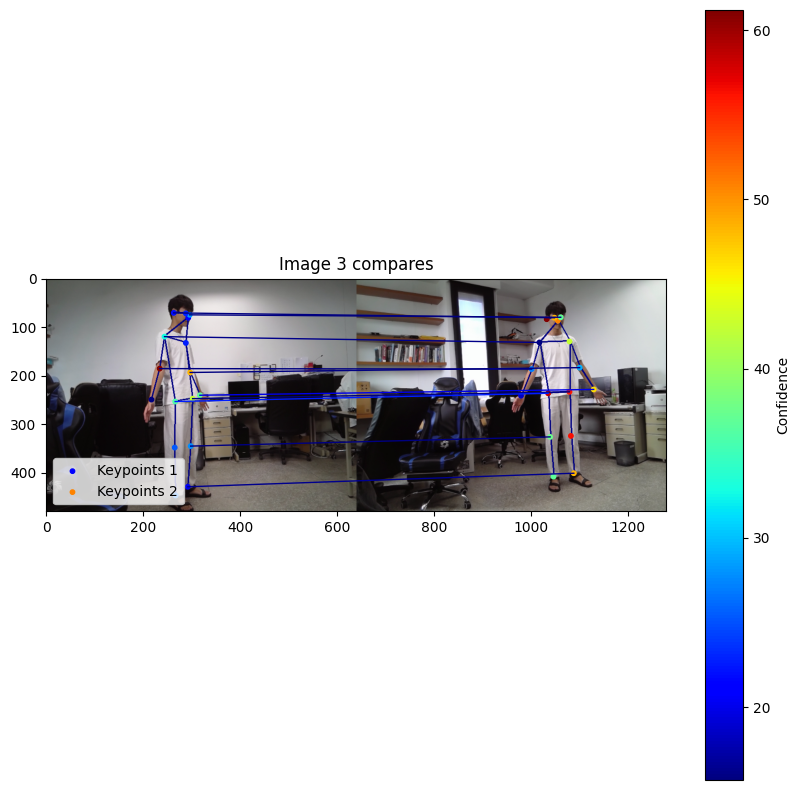

1321.2132661628884
2118.6094452773614
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0005.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0005.png: (17, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0005.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0005.png: (17, 128)


[[ 3  5  6  8  9 10 11 13 14 15]
 [ 2  6  7  9  8 11 12 14 15 16]] 
 [-0.08635962 -0.13876963 -0.17375445  0.07155067 -0.05652511  0.13889086
  0.2693519  -0.10490203 -0.01931345  0.01078939]
10 of keypoints are match


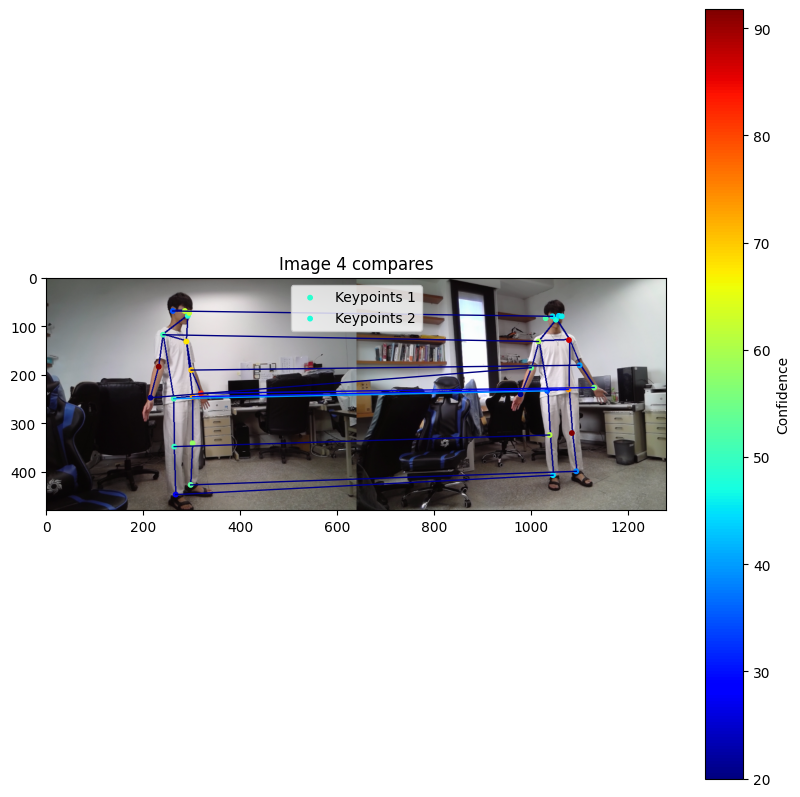

1309.2113684210526
2164.6294510385756
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0006.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0006.png: (17, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0006.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0006.png: (17, 128)


[[ 2  3  4  5  9 10 11 12 13 15]
 [ 1  2  5  6 10 11 12 13 14 16]] 
 [-0.00430655  0.01118511  0.10618407  0.15262401 -0.16027927  0.15176952
 -0.02044034  0.01474488  0.13607126 -0.10163403]
10 of keypoints are match


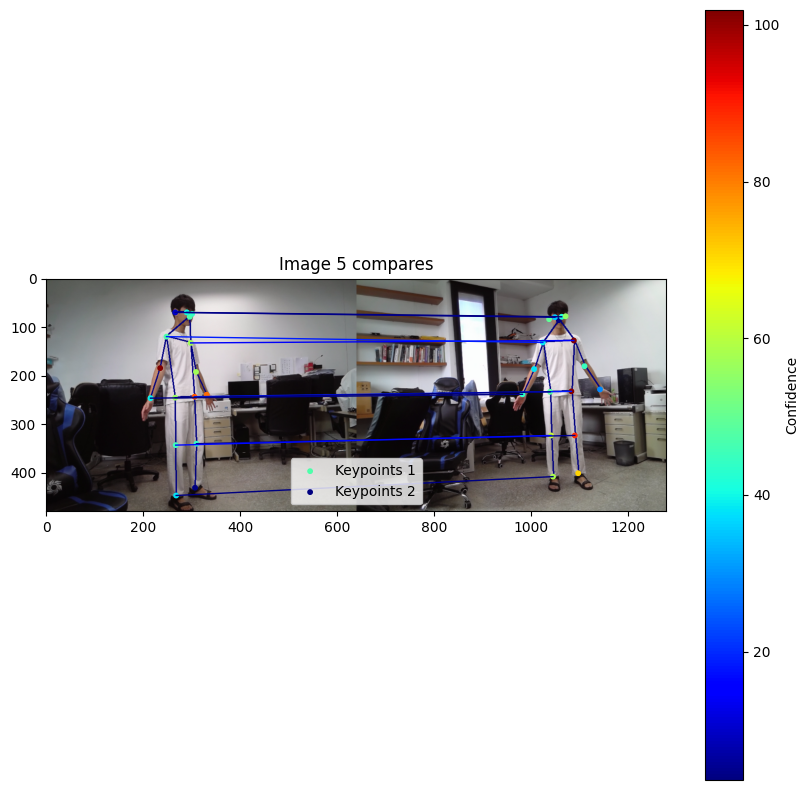

1308.8220910623945
2152.115785554728
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0007.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0007.png: (17, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120235_0007.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120235_0007.png: (17, 128)


[[ 0  2  4  5  6  8  9 10 11 12 15]
 [ 0  3  5  6  7  9 10 11 12 13 16]] 
 [-0.07091045  0.01623517 -0.03289056  0.07627654 -0.19981432 -0.07121098
 -0.13309658 -0.03987491  0.30846798  0.034293   -0.09779096]
11 of keypoints are match


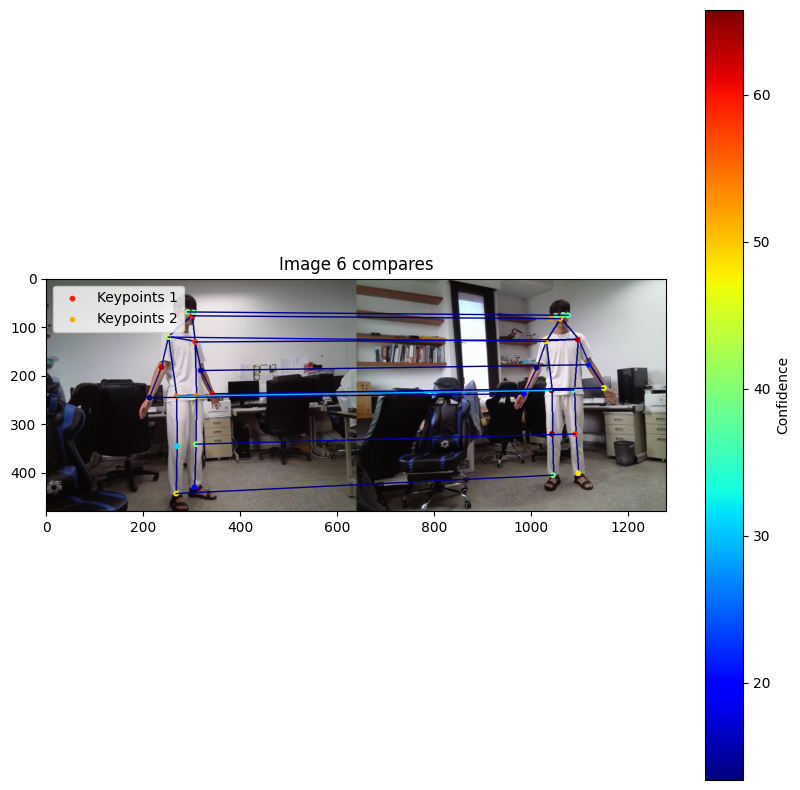

1328.3347547974413
2160.005175600739
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120236_0008.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120236_0008.png: (17, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120236_0008.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120236_0008.png: (17, 128)


[[ 2  4  5  6  7  9 10 11 12 15]
 [ 1  5  6  7  8 10 11 12 13 16]] 
 [ 0.09847873 -0.04802203 -0.14336002  0.088139   -0.26142836 -0.20900917
  0.03243911  0.3216836   0.00398839  0.02186513]
10 of keypoints are match


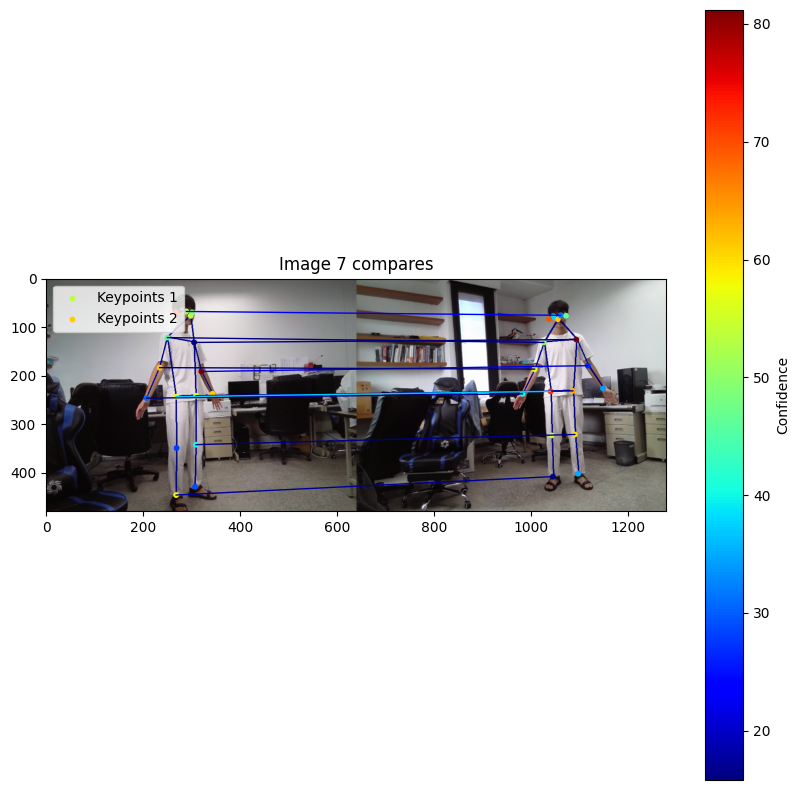

1309.73352793995
2134.2106847253576
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120236_0009.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120236_0009.png: (17, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120236_0009.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120236_0009.png: (17, 128)


[[ 0  1  2  4  5  6  7  8  9 10 11 14 15]
 [ 0  1  2  5  6  7  8  9 10 11 12 15 16]] 
 [ 0.02131099 -0.08974898  0.09189206  0.08761942  0.08559221 -0.05035949
 -0.06222939  0.25347513 -0.17532897  0.12110996  0.346896    0.0526641
  0.02206814]
13 of keypoints are match


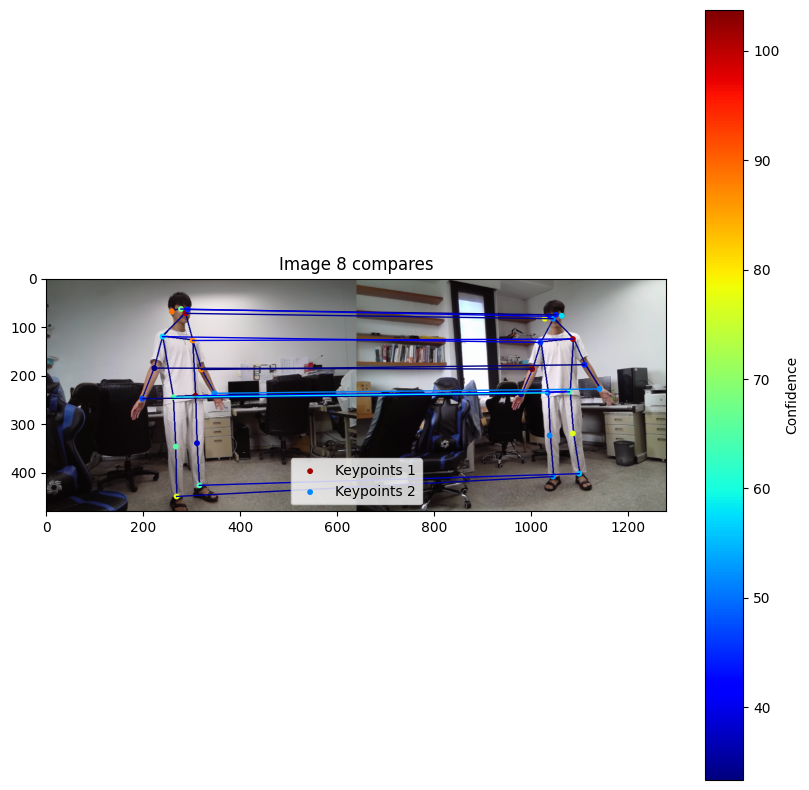

1323.249152542373
2179.11345646438
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120236_0010.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120236_0010.png: (17, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120236_0010.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120236_0010.png: (17, 128)


[[ 1  3  4  5  6  8  9 10 11 12 13 14 15]
 [ 3  4  5  6  7  9 10 11 12 13 14 15 16]] 
 [ 0.06127268 -0.01042283  0.03137213  0.02730066  0.01140141 -0.03947651
 -0.09506643 -0.07184446 -0.05242586  0.0594638   0.13623744  0.08914876
 -0.07711852]
13 of keypoints are match


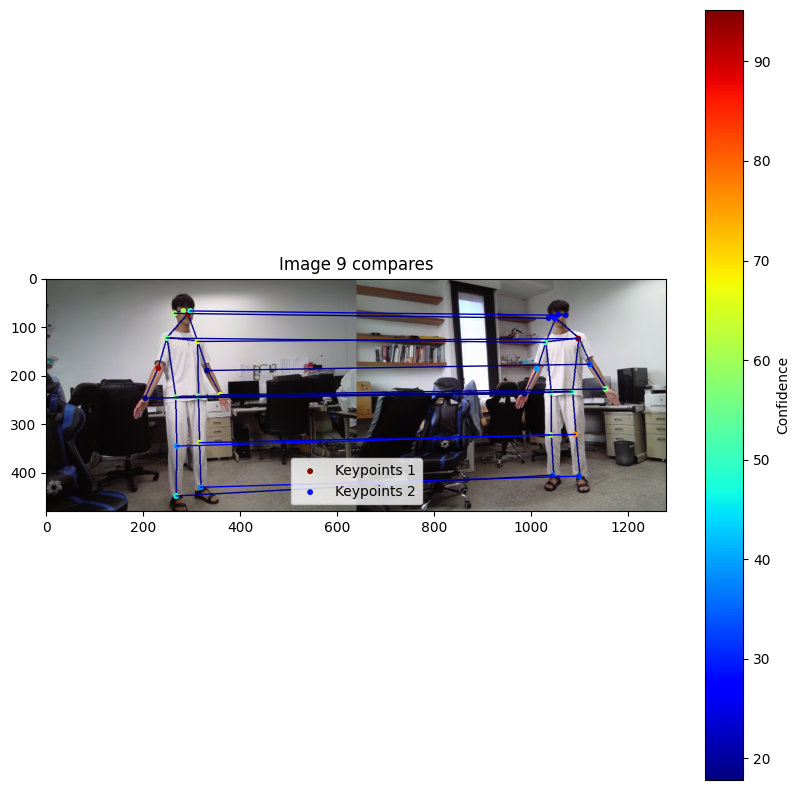

1298.694211409396
2186.3565480696443
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120236_0011.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120236_0011.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120236_0011.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120236_0011.png: (16, 128)


[[ 1  2  4  5  6  7 11 13 14 15]
 [ 3  1  4  5  8  2 11 13 14 15]] 
 [-0.06431007  0.10621744  0.24308896  0.02647138  0.08840185 -0.1685934
  0.07674611  0.21679294  0.25763023  0.02867496]
10 of keypoints are match


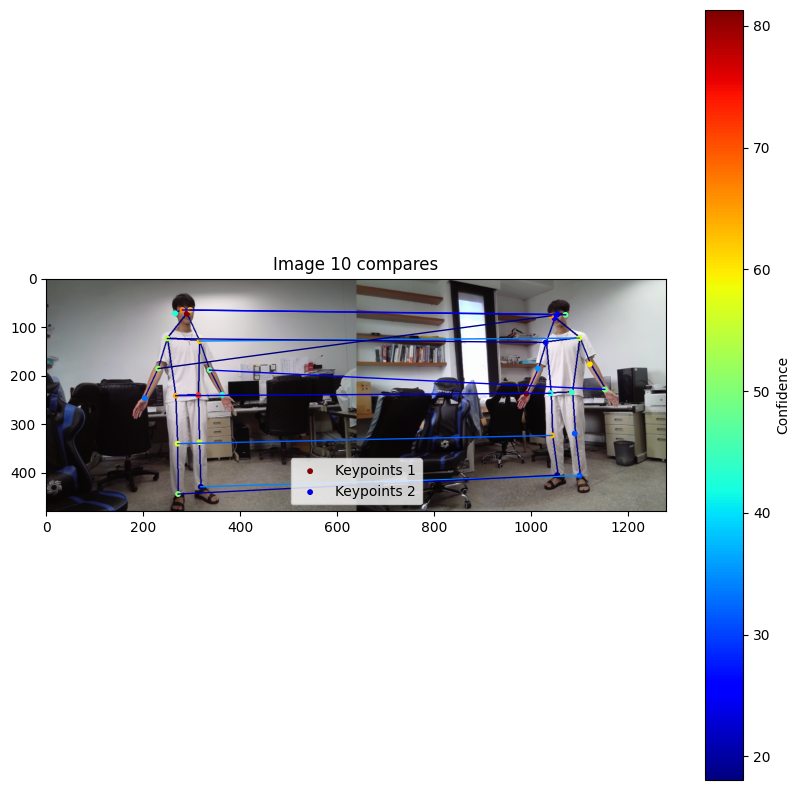

1317.5518987341773
2153.027932960894
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120237_0012.png: (17, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120237_0012.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120237_0012.png: (17, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120237_0012.png: (16, 128)


[[ 0  2  6  7  9 11 12 15 16]
 [ 0  3  5  6  8  4 11 14 15]] 
 [-0.00386822  0.01768458  0.02677691  0.51043296  0.24423426 -0.07853055
 -0.01401198  0.12261677  0.03430855]
9 of keypoints are match


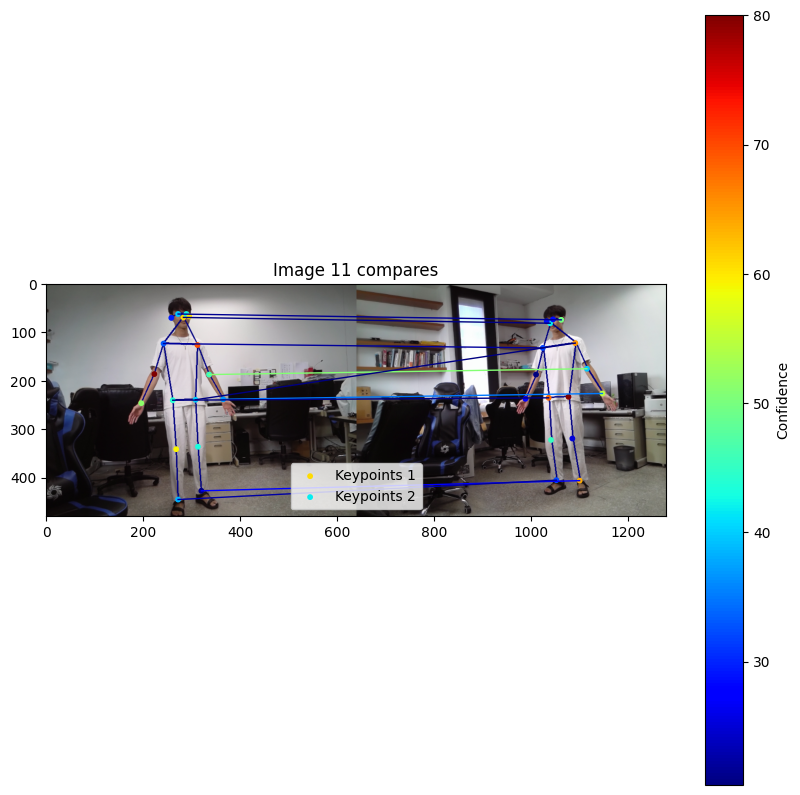

1314.4125844594594
2147.527184101987
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120237_0013.png: (17, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120237_0013.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120237_0013.png: (17, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120237_0013.png: (16, 128)


[[ 1  6  7  8  9 10 11 12 13 15]
 [ 3  5  6  7  8  9  4 11 13 14]] 
 [ 0.11262721 -0.140499   -0.14311922 -0.11553216  0.10027707 -0.09773219
 -0.06828749 -0.13844645 -0.11427164  0.11711764]
10 of keypoints are match


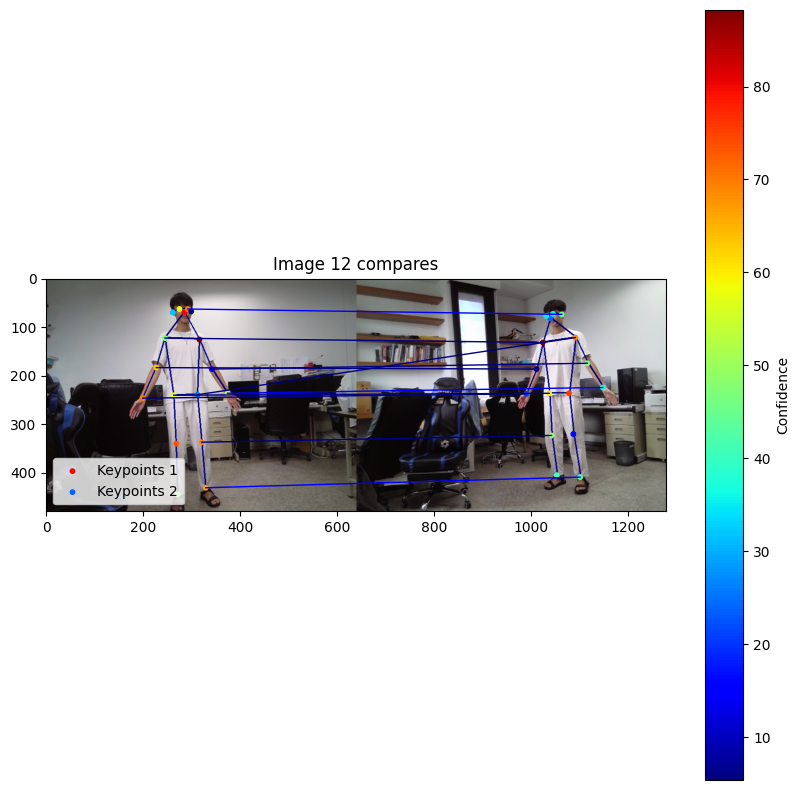

1305.9328327075511
2190.2990619136963
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120237_0014.png: (17, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120237_0014.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120237_0014.png: (17, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120237_0014.png: (16, 128)


[[ 0  1  2  5  7  8  9 12 14 15 16]
 [ 0  3  1  4  6  7  8  5 11 14 15]] 
 [ 0.09274697 -0.02994037  0.10753673  0.3379681  -0.1415757   0.16624725
 -0.06269419 -0.04583645 -0.08377516 -0.05746377 -0.03781581]
11 of keypoints are match


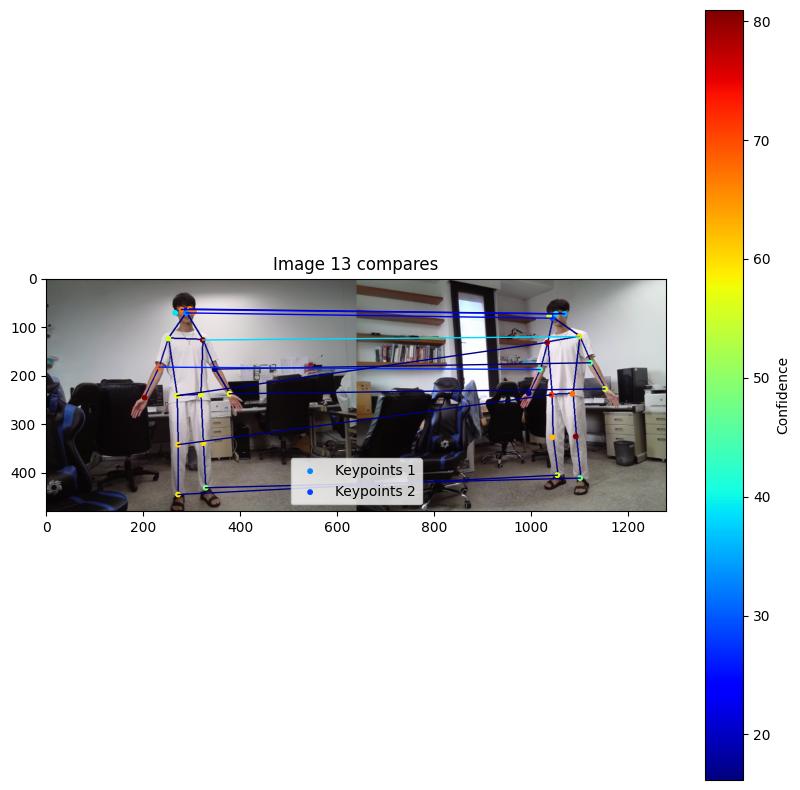

1303.1513877207738
2192.958827893175
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120237_0015.png: (17, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120237_0015.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120237_0015.png: (17, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120237_0015.png: (16, 128)


[[ 1  5  6  7  8  9 10 11 12 13 14 15]
 [ 3  4  5  6  7  8  9 10 11 12 13 14]] 
 [ 0.08239573 -0.17821527  0.19487822 -0.1751318   0.1803037  -0.03467071
 -0.12806499 -0.1486119  -0.12794733 -0.14398217  0.2771768  -0.06200361]
12 of keypoints are match


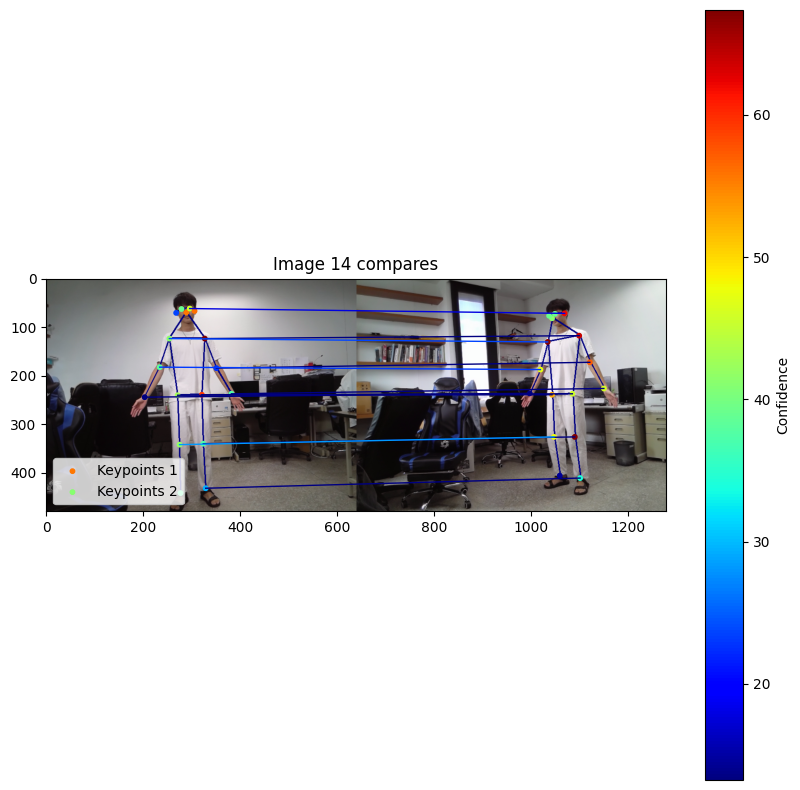

1328.3127104377104
2156.989501312336
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120237_0016.png: (17, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120237_0016.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120237_0016.png: (17, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120237_0016.png: (16, 128)


[[ 1  6  9 11 12 13 14 15 16]
 [ 3  5  8 10 11 12 13 14 15]] 
 [ 0.06746453 -0.02883065  0.04476947  0.01340461 -0.11691844 -0.20125818
 -0.16546822  0.05969286  0.01384133]
9 of keypoints are match


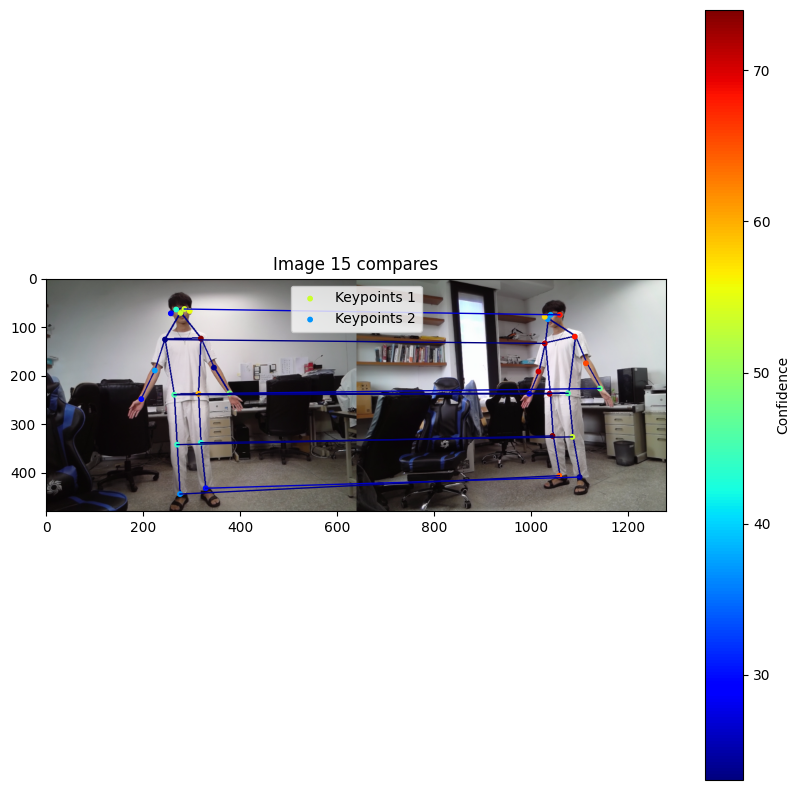

1312.1901763224182
2168.275784753363
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120238_0017.png: (17, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120238_0017.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120238_0017.png: (17, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120238_0017.png: (16, 128)


[[ 1  2  5  6  7  8 11 12 13 14 16]
 [ 3  0  4  5  6  9 10 11 13 12 15]] 
 [ 0.08511519 -0.13405454  0.42902762 -0.00620854 -0.18795025  0.01142091
 -0.02735424 -0.09590852 -0.07896733 -0.10392094  0.07993656]
11 of keypoints are match


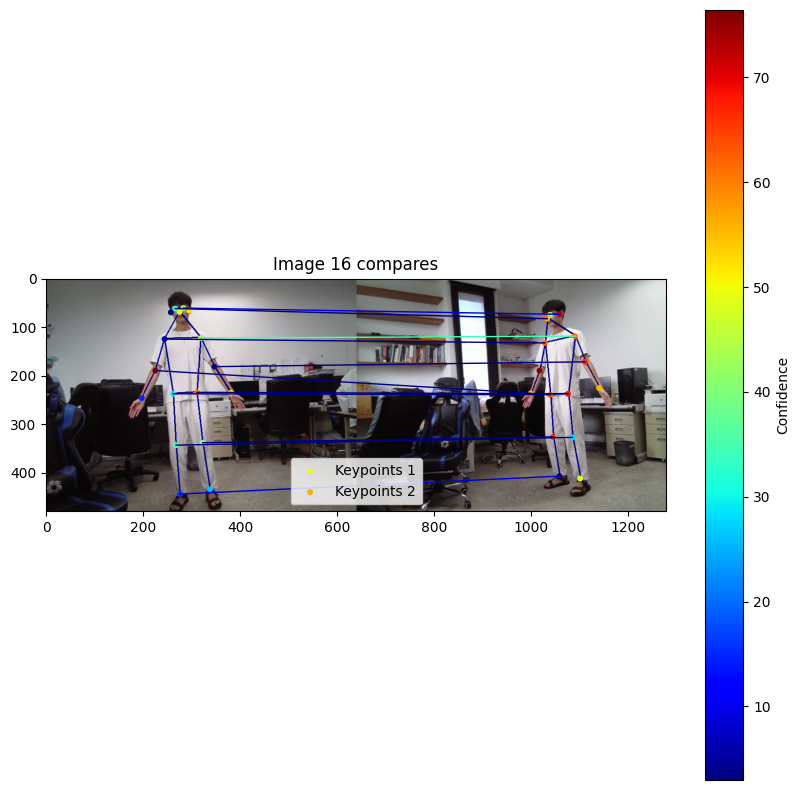

1329.2147395171537
2190.7351190476193
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120238_0018.png: (17, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120238_0018.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120238_0018.png: (17, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120238_0018.png: (16, 128)


[[ 1  2  4  5  7  9 10 12 13 14 16]
 [ 1  2  0  4  6  8  9 11 12 13 15]] 
 [-0.03775108 -0.09691715 -0.05934048  0.39419878  0.51205075  0.14701402
 -0.21097624 -0.03964353  0.07231098  0.10478753 -0.03626442]
11 of keypoints are match


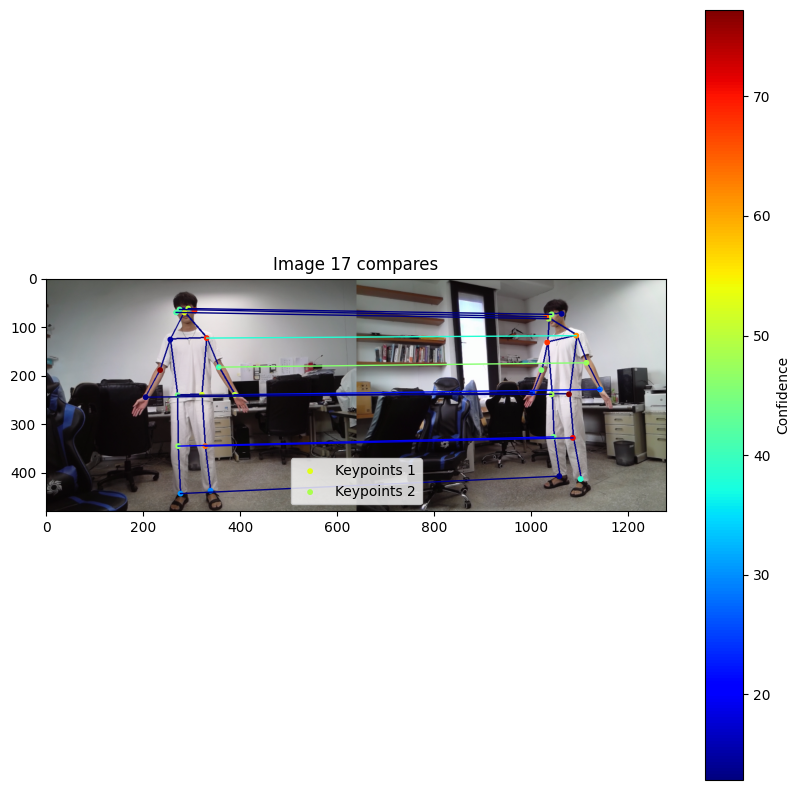

1343.6856540084389
2208.311377245509
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120238_0019.png: (17, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120238_0019.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120238_0019.png: (17, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120238_0019.png: (16, 128)


[[ 0  2  3  4  5  6  7  8 13 14 15 16]
 [ 0  1  3  2  4  5  6  7 12 13 14 15]] 
 [ 0.0032956   0.02732348 -0.15045452  0.04709548  0.24147362 -0.1405809
  0.42372048 -0.10771704 -0.07234251  0.01343113  0.08095837  0.0860166 ]
12 of keypoints are match


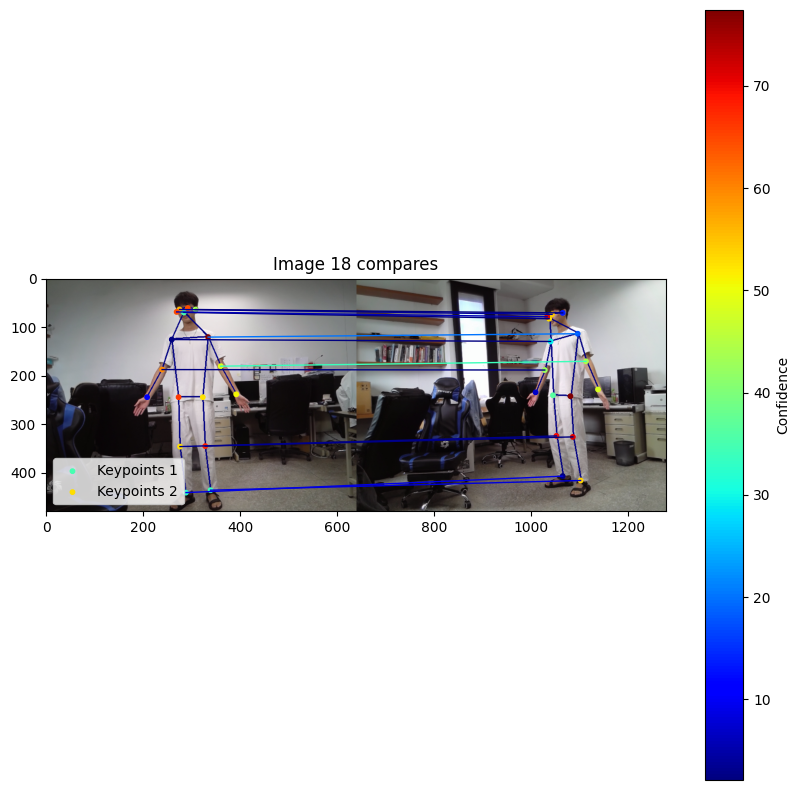

1340.178810720268
2180.4400590188125
filtered_keypoints_1.shape for data_bruh\cam1_pose\cam1_20240912_120238_0020.png: (16, 2)
filtered_keypoints_2.shape for data_bruh\cam2_pose\cam2_20240912_120238_0020.png: (16, 2)
descriptors_hrt1.shape for data_bruh\cam1_pose\cam1_20240912_120238_0020.png: (16, 128)
descriptors_hrt2.shape for data_bruh\cam2_pose\cam2_20240912_120238_0020.png: (16, 128)


[[ 1  2  3  4  5  6  8 11 13 14 15]
 [ 1  0  3  4  5  6  8  7 13 14 15]] 
 [-0.07093668 -0.04385054 -0.16982174  0.16783243 -0.1158936   0.41347796
 -0.00282609 -0.27237344  0.23335618 -0.03177726  0.17937636]
11 of keypoints are match


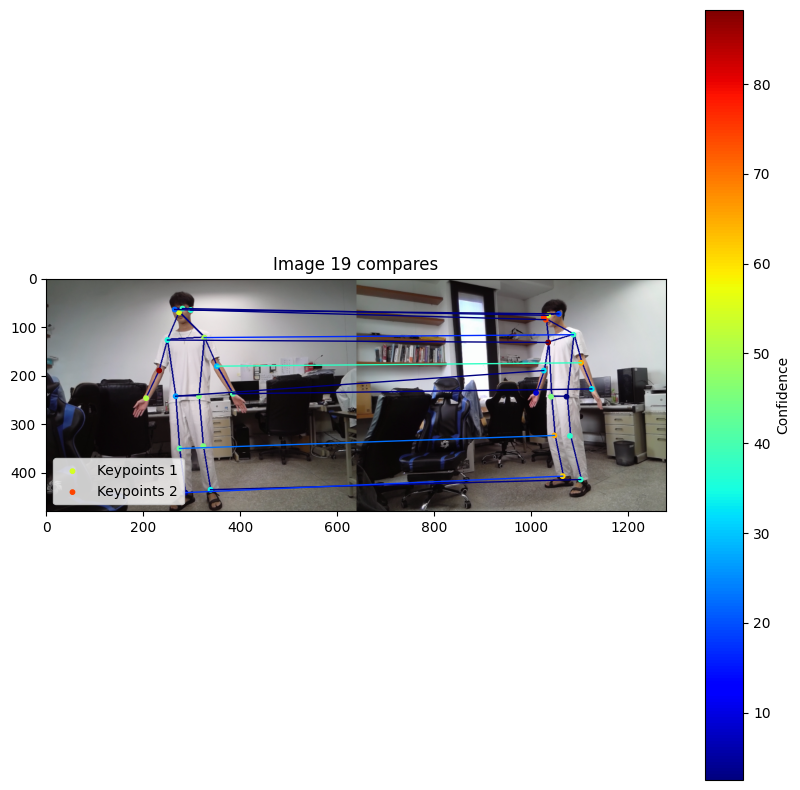

In [ ]:
counting_image = 0
#creating a new txt file
f = open(f"{folder_match}.txt", "w")

for line_2 in lines_2:
    matching_line_1 = next((line for line in lines_1 if line[25:45] == line_2[25:45]), None)
    if matching_line_1:
        #Create a new txt file storing the joints
        
        # Use regex to split the address and coordinates
        match1 = re.match(r'([^ ]+) (\[\[.*\]\])', matching_line_1) 
        if match1:
            address1 = match1.group(1)
            hrnet_coor1 = eval(match1.group(2))  # Convert the string of coordinates to a list of lists
        match2 = re.match(r'([^ ]+) (\[\[.*\]\])', line_2)
        if match2:
            address2 = match2.group(1)
            hrnet_coor2 = eval(match2.group(2))  # Convert the string of coordinates to a list of lists
        # print(f"{address1, coordinates1}\n with {address2,coordinates2}")

        keypoints_1, descriptors_1, scores_1, img_tensor1 = disk_process(address1, model, threshold = 0.0)
        keypoints_2, descriptors_2, scores_2, img_tensor2 = disk_process(address2, model, threshold = 0.0)

        keypoints_1 = format_keypoints(keypoints_1)
        keypoints_2 = format_keypoints(keypoints_2)
        
        # matching_keypoints and indices
        filtered_keypoints_1, indices_hrt1 = get_matching_keypoints_indices(hrnet_coor1, keypoints_1, tolerance_range=8)
        filtered_keypoints_2, indices_hrt2 = get_matching_keypoints_indices(hrnet_coor2, keypoints_2, tolerance_range=8)

        score_hrt1 = scores_1[indices_hrt1]
        score_hrt2 = scores_2[indices_hrt2]

        descriptors_hrt1 = descriptors_1[indices_hrt1]
        descriptors_hrt2 = descriptors_2[indices_hrt2]

        print(f"filtered_keypoints_1.shape for {address1}: {np.array(filtered_keypoints_1).shape}")
        print(f"filtered_keypoints_2.shape for {address2}: {np.array(filtered_keypoints_2).shape}")
        print(f"descriptors_hrt1.shape for {address1}: {descriptors_hrt1.shape}")
        print(f"descriptors_hrt2.shape for {address2}: {descriptors_hrt2.shape}")
        print("\n")
        
        matches, scores, num_matches = match_images(descriptors_hrt1, descriptors_hrt2, rt=1, use_brute=False)

        print(matches,"\n", scores)

        image1_path = address1
        image1 = cv2.imread(image1_path)
        if image1 is None:
            raise FileNotFoundError(f"Image at {image1_path} could not be loaded.")

        image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

        image2_path = address2
        image2 = cv2.imread(image2_path)
        if image2 is None:
            raise FileNotFoundError(f"Image at {image2_path} could not be loaded.")

        image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

        print(f'{num_matches} of keypoints are match')
        keypoints_match = return_match_keypoints(filtered_keypoints_1, filtered_keypoints_2, matches, scores)
        output = f"match keypoints image{counting_image}" + " " + str(keypoints_match) + '"\n'
        f.write(output)

        # Visualize matches
        visualize_matches(image1_rgb, filtered_keypoints_1, image2_rgb, filtered_keypoints_2, matches, score_hrt1, score_hrt2, scores, counting_image)
        counting_image += 1

#closing txt file
f.close()